In [ ]:
# Mounting the drive so that dataset can be loaded

from google.colab import drive
drive.mount('/content/drive')

In [5]:
# Essential libraries
import numpy as np 
import pandas as pd
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras import applications,activations
from keras.preprocessing.image import ImageDataGenerator,load_img,img_to_array
from keras import optimizers,utils
from keras.models import Sequential, Model 
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D,BatchNormalization,ZeroPadding2D, Input
from keras.layers import Conv2D, Activation,MaxPooling2D
from keras import backend as k 
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping

In [ ]:
dataset_folder_name = '/content/drive/My Drive/Images'
TRAIN_TEST_SPLIT = 0.8
IM_WIDTH = IM_HEIGHT = 198

dataset_dict = {
    'race_id': {
        0: 'white', 
        1: 'black', 
        2: 'asian', 
        3: 'indian', 
        4: 'others'
    },
    'gender_id': {
        0: 'male',
        1: 'female'
    }
}

dataset_dict['gender_alias'] = dict((g, i) for i, g in dataset_dict['gender_id'].items())    # (Gender: id)
dataset_dict['race_alias'] = dict((r, i) for i, r in dataset_dict['race_id'].items())        # (Race: id)

In [ ]:
# Let's also define a function to help us on extracting the data from our dataset. This function will be
# used to iterate over each file of the UTK dataset and return a Pandas Dataframe containing all the
# fields (age, gender and sex) of our records.

def parse_dataset(dataset_path, ext='jpg'):
    """
    Used to extract information about our dataset. It does iterate over all images and return a DataFrame
     with the data (age, gender and sex) of all files.
    """
    def parse_info_from_file(path):
        """
        Parse information from a single file
        """
        try:
            filename = os.path.split(path)[1]
            filename = os.path.splitext(filename)[0]
            age, gender, race, _ = filename.split('_')

            return int(age), dataset_dict['gender_id'][int(gender)], dataset_dict['race_id'][int(race)]
        except Exception as ex:
            return None, None, None
        
    files = glob.glob(os.path.join(dataset_path, "*.%s" % ext))
    
    records = []
    for file in files:
        info = parse_info_from_file(file)
        records.append(info)
        
    df = pd.DataFrame(records)
    df['file'] = files
    df.columns = ['age', 'gender', 'race', 'file']
    
   
    df = df.dropna()
    
    return df

In [ ]:

df = parse_dataset(dataset_folder_name)
df.head()

# Now we have a pandas dataframe with us. This can be dealt with quite easily. Like, we simply now need 
# to OHE gender, race and feed it into model. Using Pandas dataframe also allows me to manipulate and 
# visualize data by plotting graphs.

,age,gender,race,file
0,17.0,male,others,/content/drive/My Drive/Images/17_0_4_20170103...
1,17.0,female,white,/content/drive/My Drive/Images/17_1_0_20170102...
2,17.0,male,others,/content/drive/My Drive/Images/17_0_4_20170102...
3,17.0,female,white,/content/drive/My Drive/Images/17_1_0_20170103...
4,17.0,male,others,/content/drive/My Drive/Images/17_0_4_20170103...


## Data Generator

In [ ]:
from keras.utils import to_categorical
from PIL import Image
p = np.random.permutation(len(df))

train_up_to = int(len(df) * TRAIN_TEST_SPLIT)      
train_idx = p[:train_up_to]
val_idx = p[train_up_to:]

# converts alias to id
df['gender_id'] = df['gender'].map(lambda gender: dataset_dict['gender_alias'][gender])
df['race_id'] = df['race'].map(lambda race: dataset_dict['race_alias'][race])

# Now we got train_idx, valid_idx, test_idx
            
def preprocess_image(img_path):   # Used to perform some minor preprocessing on the image before inputting into the network.
    
    im = Image.open(img_path)
    im = im.resize((IM_WIDTH, IM_HEIGHT))
    im = np.array(im) / 255.0
    
    return im
        
def generate_images(image_idx, is_training, batch_size=16):  # Used to generate a batch with images when training/validating our model.
    
    # arrays to store our batched data
    images, ages, races, genders = [], [], [], []

    while True:
        for idx in image_idx:
            person = df.iloc[idx]
            
            age = person['age']
            race = person['race_id']
            gender = person['gender_id']
            file = person['file']
            
            im = preprocess_image(file)
            
            races.append(to_categorical(race, len(dataset_dict['race_id'])))
            genders.append(to_categorical(gender, len(dataset_dict['gender_id'])))
            ages.append(to_categorical(age,5))
            images.append(im)
            
            # yielding condition
            if len(images) >= batch_size:
                yield np.array(images), [np.array(ages), np.array(genders)]
                images, ages, genders = [], [], []
                
        if not is_training:
            break
            

## Model Architecture

In [ ]:
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import SeparableConv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Dropout
from keras.layers import SpatialDropout2D
from keras.layers.core import Lambda
from keras.layers.core import Dense
from keras.layers import Flatten
from keras.layers import Input
from keras.regularizers import l2

import tensorflow as tf

def make_default_hidden_layers(inputs):

    x = SeparableConv2D(32, (3, 3), padding="same")(inputs)
    x = Activation("relu")(x)
    x = MaxPooling2D(pool_size=(3, 3))(x)
    x = BatchNormalization(axis=-1)(x)

    x = SeparableConv2D(64, (3, 3), padding="same")(x)
    x = Activation("relu")(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = BatchNormalization(axis=-1)(x)

    x = SeparableConv2D(128, (3, 3), padding="same")(x)
    x = Activation("relu")(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = BatchNormalization(axis=-1)(x)

    x = SeparableConv2D(128, (3, 3), padding="same")(x)
    x = Activation("relu")(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = SpatialDropout2D(0.1)(x)
    x = BatchNormalization(axis=-1)(x)

    x = SeparableConv2D(256, (3, 3), padding="same")(x)
    x = Activation("relu")(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = SpatialDropout2D(0.1)(x)
    x = BatchNormalization(axis=-1)(x)

    x = SeparableConv2D(256, (3, 3), padding="same")(x)
    x = Activation("relu")(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = SpatialDropout2D(0.15)(x)
    x = BatchNormalization(axis=-1)(x)

    x = SeparableConv2D(256, (3, 3), padding="same")(x)
    x = Activation("relu")(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = SpatialDropout2D(0.15)(x)
    x = BatchNormalization(axis=-1)(x)

    return x

def build_gender_branch(inputs):
  
    x = make_default_hidden_layers(inputs)

    x = Flatten()(x)
    x = Dense(64)(x)
    x = Activation("relu")(x)
    x = Dropout(0.3)(x)
    x = BatchNormalization()(x)

    x = Dense(32)(x)
    x = Activation("relu")(x)
    x = Dropout(0.25)(x)
    x = BatchNormalization()(x)
  
    x = Dense(2)(x)
    x = Activation("softmax", name="gender_output")(x)

    return x

def build_age_branch(inputs):   

    x = make_default_hidden_layers(inputs)
    
    x = Flatten()(x)
    x = Dense(128, kernel_regularizer=l2(0.03))(x)
    x = Activation("relu")(x)
    x = Dropout(0.3)(x)
    x = BatchNormalization()(x)

    x = Dense(64)(x)
    x = Activation("relu")(x)
    x = Dropout(0.3)(x)
    x = BatchNormalization()(x)
    
    x = Dense(32)(x)
    x = Activation("relu")(x)
    x = Dropout(0.2)(x)
    x = BatchNormalization()(x)

    x = Dense(5)(x)
    x = Activation("softmax", name="age_output")(x)  

    return x


def assemble_model(width, height):
  
    input_shape = (height, width, 3)
    inputs = Input(shape=input_shape)

    age_branch = build_age_branch(inputs)
    gender_branch = build_gender_branch(inputs)

    model = Model(inputs=inputs, outputs = [age_branch, gender_branch], name="face_net")

    return model
    
model = assemble_model(198, 198)

In [ ]:
model.summary()

Model: "face_net"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 198, 198, 3)  0                                            
__________________________________________________________________________________________________
separable_conv2d_25 (SeparableC (None, 198, 198, 32) 155         input_3[0][0]                    
__________________________________________________________________________________________________
activation_35 (Activation)      (None, 198, 198, 32) 0           separable_conv2d_25[0][0]        
__________________________________________________________________________________________________
max_pooling2d_25 (MaxPooling2D) (None, 66, 66, 32)   0           activation_35[0][0]              
___________________________________________________________________________________________

In [ ]:
# A callback is a set of functions to be applied at given stages of the training procedure.

import math
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.callbacks import LearningRateScheduler

#  When training a neural network, the learning rate is often the most important 
# hyperparameter to tune. When training deep neural networks, it is often useful 
# to reduce learning rate as the training progresses.

# LRS in Keras reduces the learning rate by a certain factor after certain no of epochs

def step_decay(epoch):
	initial_lrate = 0.008
	drop = 0.5
	epochs_drop = 5.0
	lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
	return lrate      

opt = Adam(lr=0.0)                                     # 0.0 here signifies this is not to be used
lrate = LearningRateScheduler(step_decay)

model.compile(optimizer=opt, 
              loss={
                  'age_output': 'categorical_crossentropy', 
                  'gender_output': 'categorical_crossentropy'},
              metrics={
                  'age_output': 'accuracy', 
                  'gender_output': 'accuracy'})

callbacks_list = [lrate]

# It is this callback that allows a function to invoke during program execution.

In [ ]:
from sklearn.utils import class_weight
class_weight = class_weight.compute_class_weight('balanced' ,np.array([0,1,2,3,4]) ,np.array(df['age']))


class_weight1 = {'age_output': class_weight}

In [ ]:
import math
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.callbacks import LearningRateScheduler

def step_decay(epoch):
	initial_lrate = 0.002
	drop = 0.5
	epochs_drop = 7.0
	lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
	return lrate      

opt = Adam(lr=0.0)
lrate = LearningRateScheduler(step_decay)

train_gen = generate_images(train_idx, is_training=True, batch_size=32)
valid_gen = generate_images(val_idx, is_training=True, batch_size=32)
callbacks_list = [lrate]

history = model.fit(train_gen, steps_per_epoch = len(train_idx)//32, epochs=22  , callbacks=callbacks_list,
                     validation_data=valid_gen, validation_steps=len(val_idx)//32)



In [ ]:
model.save('/content/drive/My Drive/Facial Demographics/a_g_CNN.h5')         # Saving the above run model. It has performed best till date.

---

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from keras.models import load_model
new_model = load_model('/content/drive/My Drive/Facial Demographics/a_g_CNN.h5')

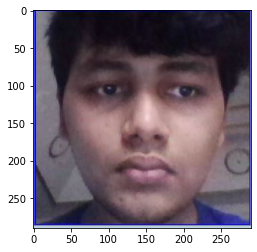

0-24 yrs old
Male


In [6]:
from keras.preprocessing import image
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
 
def loadImage(filepath):
  test_img = image.load_img(filepath, target_size=(198, 198))
  test_img = image.img_to_array(test_img)
  test_img = np.expand_dims(test_img, axis = 0)
  test_img /= 255
  return test_img

# Predicting the results on my own's image (intentionally taken with a low quality camera)!!
# I am a 22 yrs old male 

picture = "/content/drive/My Drive/Facial Demographics/Jash.JPG"                                     
age_pred, gender_pred = new_model.predict(loadImage(picture))
img = image.load_img(picture)                        
plt.imshow(img)
plt.show()
max=-1
count=0

for i in age_pred[0]:
  if i>max:
    max = i
    temp = count
  count+=1

if temp==0:
  print('0-24 yrs old')
if temp==1:
  print('25-49 yrs old')
if temp==2:
  print('50-74 yrs old')
if temp==3:
  print('75-99 yrs old')
if temp==4:
  print('91-124 yrs old')

if gender_pred[0][0]>gender_pred[0][1]:
  print('Male')
else:
  print('Female')
